In [70]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [4]:
from PIL import Image
from IPython.display import display  # Only for notebook

import warnings
warnings.filterwarnings('ignore')

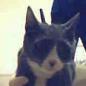

In [5]:
with Image.open('../Data/CATS_DOGS/test/CAT/10107.jpg') as im:
    display(im)

In [6]:
path = "../Data/CATS_DOGS/"
img_names = []

for folder,subfolders,filenames in os.walk(path):
    for img in filenames:
        img_names.append(folder+'/'+img)

In [13]:
# Less images and more complex than the toy datasets

In [14]:
img_size = []
rejected = []

for item in img_names:
    try:
        with Image.open(item) as img:
            img_size.append(img.size)
            
    except:
        rejected.append(item)  # if it's too small or error...

In [17]:
print(len(img_size))
print(len(rejected))

24994
0


In [19]:
df = pd.DataFrame(img_size)

In [21]:
df[1].describe()

count    24994.000000
mean       361.037129
std         96.936811
min         33.000000
25%        302.000000
50%        375.000000
75%        421.000000
max        500.000000
Name: 1, dtype: float64

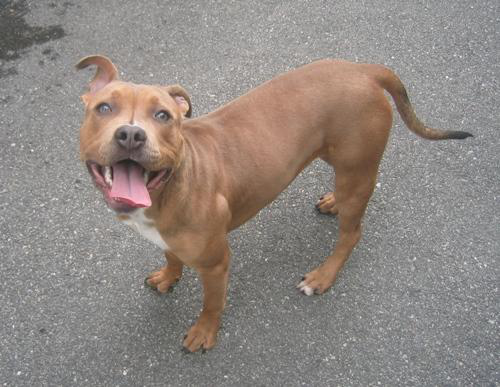

In [22]:
dog = Image.open('../Data/CATS_DOGS/train/DOG/14.jpg')
display(dog)

In [24]:
dog.size

(500, 387)

In [26]:
dog.getpixel((0,0))  # RGB channel pixel 0 -- 255

(90, 95, 98)

In [28]:
transform = transforms.Compose([   # can take list of transformations
    transforms.ToTensor() # transposes axes widht and length   
])
im = transform(dog)
print(type(im))
print(im.shape)

<class 'torch.Tensor'>
torch.Size([3, 387, 500])


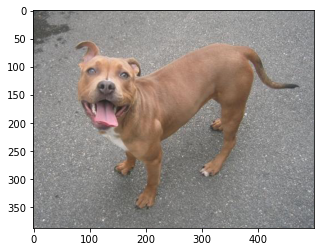

In [30]:
plt.imshow(im.numpy().transpose(1,2,0))  # matplotlib doesn't like tensor format, (needs (387,500,3))

In [31]:
im  # Values are normalized

tensor([[[0.3529, 0.3451, 0.3373,  ..., 0.5686, 0.5333, 0.5216],
         [0.3255, 0.3412, 0.3333,  ..., 0.5765, 0.5451, 0.5294],
         [0.2863, 0.3216, 0.3373,  ..., 0.5529, 0.5255, 0.4980],
         ...,
         [0.5765, 0.5451, 0.4824,  ..., 0.5686, 0.5059, 0.5216],
         [0.6157, 0.5922, 0.4941,  ..., 0.5294, 0.5176, 0.5176],
         [0.5922, 0.5843, 0.5020,  ..., 0.5882, 0.6314, 0.6039]],

        [[0.3725, 0.3647, 0.3569,  ..., 0.5725, 0.5373, 0.5255],
         [0.3451, 0.3608, 0.3529,  ..., 0.5804, 0.5490, 0.5333],
         [0.3059, 0.3412, 0.3569,  ..., 0.5569, 0.5294, 0.5020],
         ...,
         [0.5608, 0.5294, 0.4745,  ..., 0.5765, 0.5137, 0.5294],
         [0.6000, 0.5765, 0.4863,  ..., 0.5373, 0.5255, 0.5255],
         [0.5765, 0.5686, 0.4941,  ..., 0.5961, 0.6392, 0.6118]],

        [[0.3843, 0.3765, 0.3686,  ..., 0.5882, 0.5529, 0.5412],
         [0.3569, 0.3725, 0.3647,  ..., 0.5961, 0.5647, 0.5490],
         [0.3176, 0.3529, 0.3686,  ..., 0.5725, 0.5451, 0.

In [32]:
im[:,0,0]

tensor([0.3529, 0.3725, 0.3843])

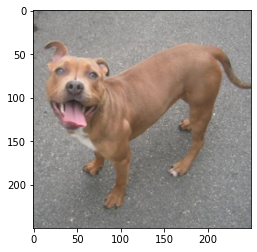

In [44]:
transform = transforms.Compose([   # can take list of transformations
    # transforms.Resize((224,224)),  # can resize smaller edge or resize both axes with tuple
    transforms.Resize(250),
    transforms.CenterCrop(250),
    transforms.ToTensor() # transposes axes widht and length   
])
im = transform(dog)
plt.imshow(im.numpy().transpose(1,2,0))  # matplotlib doesn't like tensor format, (needs (387,500,3))

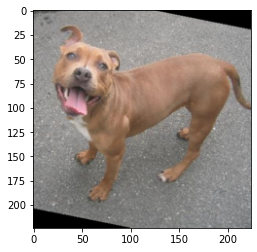

In [61]:
# Create more robust dataset
transform = transforms.Compose([   # can take list of transformations
    transforms.RandomHorizontalFlip(p=0.5), # Random horizontal flip
    transforms.RandomRotation(30),  # randomly somewhere between -30 and 30°
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor() # transposes axes widht and length   
])
im = transform(dog)
plt.imshow(im.numpy().transpose(1,2,0))  # matplotlib doesn't like tensor format, (needs (387,500,3))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


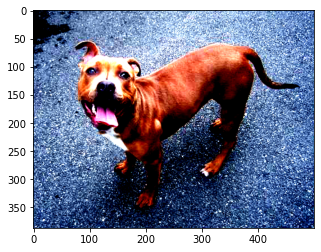

In [69]:
# Use other normalizations from pretrained networks
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])  # use common values for each channel from research
])
im = transform(dog)
plt.imshow(im.numpy().transpose(1,2,0))  


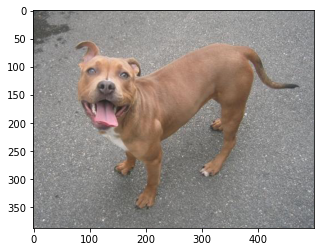

In [66]:
# Inverse transform
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

# Now CNN

In [71]:
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),  # default p = 0.5
    transforms.Resize(224),  # due to mean/median sizes
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])  # use common values for each channel from research
])

In [72]:
# Test set should not be randomly transformed, but same sizes
test_transform = transforms.Compose([
    transforms.Resize(224),  # due to mean/median sizes
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])  # use common values for each channel from research
])

In [75]:
# Load in sets using DataLoaders
root = '../Data/CATS_DOGS/'

train_data = datasets.ImageFolder(os.path.join(root,'train'),transform=train_transform)

test_data = datasets.ImageFolder(os.path.join(root,'test'),transform=test_transform)

torch.manual_seed(42)

train_loader = DataLoader(train_data,batch_size=10,shuffle=True)  # batch size can be played around with, 10 performes nice
test_loader = DataLoader(test_data,batch_size=10)

class_names = train_data.classes  # subdirectories names in train and test


In [79]:
class_names

['CAT', 'DOG']

In [78]:
len(train_data)

18743

In [80]:
for images,labels in train_loader:
    break

In [82]:
images.shape

torch.Size([10, 3, 224, 224])

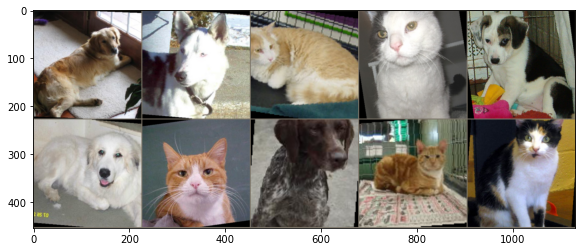

In [83]:
im = make_grid(images,nrow=5)

inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)))

In [150]:
class ConvolutionalNetwork(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,6,3,1)
        self.conv2 = nn.Conv2d(6,16,3,1)
        # start reducing with linear layers
        self.fc1 = nn.Linear(54*54*16,120) # 120 neurons, can experiment with this
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,2)
        
    def forward(self,X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2)  # 2x2, with stride of 2
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2)
        # Linear layers: Need to flatten out
        X = X.view(-1,54*54*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        
        #Final activation function (not relu but softmax due to classification)
        return F.log_softmax(X,dim=1)
        
        

In [151]:
(((224-2)/2)-2)/2  #pixels per side times filters (16)

54.5

In [152]:
torch.manual_seed(101)
CNNmodel = ConvolutionalNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNNmodel.parameters(),lr=0.001)


In [153]:
CNNmodel  # everythin makes sense?

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

In [154]:
# Check how many parameters we have
for p in CNNmodel.parameters():
    print(p.numel())

162
6
864
16
5598720
120
10080
84
168
2


In [155]:
# Realistic images are 10x larger than before...

In [156]:
import time
start_time = time.time()

epochs = 3

max_trn_batch = 800
max_tst_batch = 300

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        
        # Limit the number of batches
        if b == max_trn_batch:
            break
        b+=1
        
        # Apply the model
        y_pred = CNNmodel(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%200 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/8000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss.detach().numpy())
    train_correct.append(trn_corr)

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            # Limit the number of batches
            if b == max_tst_batch:
                break

            # Apply the model
            y_val = CNNmodel(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss.detach().numpy())
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0  batch:  200 [  2000/8000]  loss: 0.59528661  accuracy:  55.500%
epoch:  0  batch:  400 [  4000/8000]  loss: 0.57366210  accuracy:  58.400%
epoch:  0  batch:  600 [  6000/8000]  loss: 0.69722950  accuracy:  61.317%
epoch:  0  batch:  800 [  8000/8000]  loss: 0.50440902  accuracy:  62.413%
epoch:  1  batch:  200 [  2000/8000]  loss: 0.40932554  accuracy:  71.650%
epoch:  1  batch:  400 [  4000/8000]  loss: 0.48255676  accuracy:  71.725%
epoch:  1  batch:  600 [  6000/8000]  loss: 0.45788544  accuracy:  71.133%
epoch:  1  batch:  800 [  8000/8000]  loss: 0.50628334  accuracy:  71.000%
epoch:  2  batch:  200 [  2000/8000]  loss: 0.52652830  accuracy:  74.550%
epoch:  2  batch:  400 [  4000/8000]  loss: 0.57249862  accuracy:  75.050%
epoch:  2  batch:  600 [  6000/8000]  loss: 0.59792721  accuracy:  74.550%
epoch:  2  batch:  800 [  8000/8000]  loss: 0.65891939  accuracy:  75.200%

Duration: 1738 seconds


In [157]:
torch.save(CNNmodel.state_dict(),'my3epochmodel.pt')

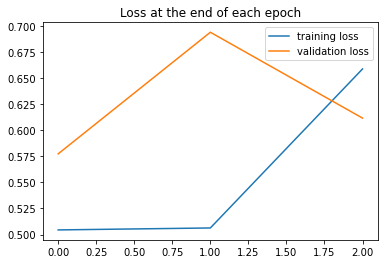

In [158]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

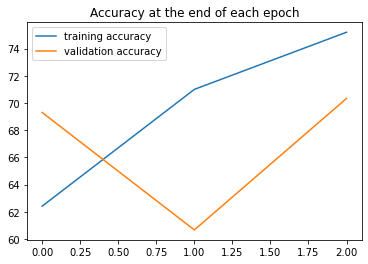

In [159]:
plt.plot([t/80 for t in train_correct], label='training accuracy')
plt.plot([t/30 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [163]:
print(test_correct)
print(f'Test accuracy: {test_correct[-1].item()*100/3000:.3f}%')

[tensor(2079), tensor(1820), tensor(2110)]
Test accuracy: 70.333%


# Use pretrained model

In [98]:
AlexNetmodel = models.alexnet(pretrained=True)  # if false would just take structures

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to C:\Users\ultracold/.cache\torch\hub\checkpoints\alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [167]:
AlexNetmodel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, 

In [168]:
for param in AlexNetmodel.parameters():
    param.requires_grad = False

In [169]:
# There are different sequential layers in the model
torch.manual_seed(42)

# Replace classifier sequence with our own but use the trained filters
AlexNetmodel.classifier = nn.Sequential(nn.Linear(9216,1024),
                                       nn.ReLU(),
                                       nn.Dropout(0.5),
                                       nn.Linear(1024,2),
                                       nn.LogSoftmax(dim=1))  # 9216 is current input in first layer in classifier sequence
AlexNetmodel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, 

In [170]:
for param in AlexNetmodel.parameters():
    print(param.numel())

23232
64
307200
192
663552
384
884736
256
589824
256
9437184
1024
2048
2


In [171]:
# We train/update only the last fully connected layers (classification) and leverage pretraining

In [172]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(AlexNetmodel.classifier.parameters(),lr=0.001)

In [173]:
import time
start_time = time.time()

epochs = 1

max_trn_batch = 800
max_tst_batch = 300

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        if b == max_trn_batch:
            break
        b+=1
        
        # Apply the model
        y_pred = AlexNetmodel(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%200 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/8000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss.detach().numpy())
    train_correct.append(trn_corr)

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            if b == max_tst_batch:
                break

            # Apply the model
            y_val = AlexNetmodel(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss.detach().numpy())
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0  batch:  200 [  2000/8000]  loss: 1.87942851  accuracy:  88.300%
epoch:  0  batch:  400 [  4000/8000]  loss: 0.04345094  accuracy:  90.200%
epoch:  0  batch:  600 [  6000/8000]  loss: 0.48087305  accuracy:  91.033%
epoch:  0  batch:  800 [  8000/8000]  loss: 0.13937432  accuracy:  91.662%

Duration: 680 seconds


In [174]:
print(test_correct[-1].item()/3000)  # accuracy

0.8986666666666666


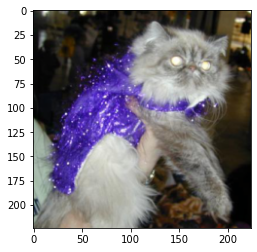

In [252]:
# Run one image through both models
image_index = 13

im = inv_normalize(test_data[image_index][0])
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))

In [253]:
# SINGLE IMAGE

CNNmodel.eval()

with torch.no_grad():
    new_pred = CNNmodel(test_data[image_index][0].view(1,3,224,224)).argmax()
    
class_names[new_pred.item()]

'DOG'

In [254]:
# SINGLE IMAGE

AlexNetmodel.eval()

with torch.no_grad():
    new_pred = AlexNetmodel(test_data[image_index][0].view(1,3,224,224)).argmax()
    
class_names[new_pred.item()]

'CAT'